In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Selecting a GPU

This is how you'll want to designate which GPU you want to use. You will have to do this at the top of each file. You can check which GPUs are available by running ``nvidia-smi`` or ``gpustat`` (nicer looking, and you'd need to run ``pip install gpustat`` on the command line)

Re sharing GPUs: people will message out / message others directly if they need a specific GPU. We haven't run into issues with this in the past!

In [2]:
from gpu_utils import restrict_GPU_pytorch
restrict_GPU_pytorch('0')

Using GPU:0


### Downloading a pre-trained model and dataset

In [3]:
import torch
from utee import selector
from utils import get_cifar100_dataloader, accuracy, inverse_normalize

model, _, _= selector.select('cifar100')
model.eval()
model.cuda() # send model to current device

dataloader = get_cifar100_dataloader(train=False)

Building and initializing cifar100 parameters
Sequential(
  (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padd

Files already downloaded and verified


### Visualize images + calculate baseline accuracy


In [4]:
n_examples = len(dataloader.dataset)

acc = 0
for data, labels in dataloader:
    data = data.cuda()
    labels = labels.cuda()
    preds = model(data)
    
    # accuracy returns list of tensor objects
    # .item() returns numerical value in tensor 
    batch_acc = accuracy(preds, labels)[0].item() 
    
    acc += batch_acc * (data.shape[0]/n_examples)
print("Top-1 Classification Accuracy: ", acc)

Top-1 Classification Accuracy:  74.27


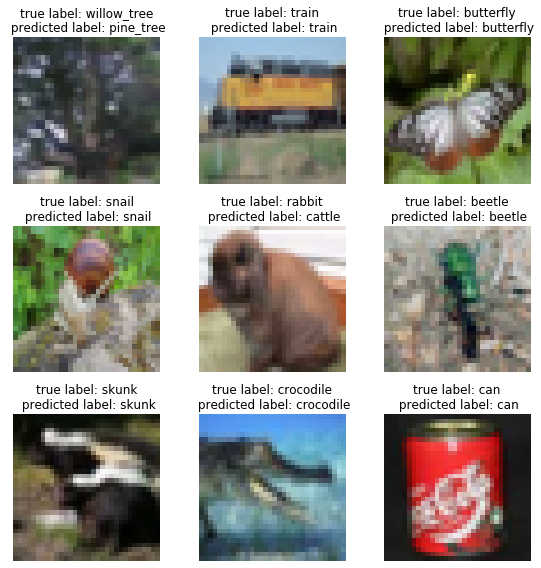

In [5]:
nc = 3
nr = 3
f, axarr = plt.subplots(nr, nc, figsize=(8, 8))

for i, ax in enumerate(axarr.ravel()):
    img = torch.clone(data[i,:,:,:])
    img = inverse_normalize(img, torch.Tensor([.5, .5, .5]), 
                            torch.Tensor([.5, .5, .5]))
    img = img.cpu().numpy()
    img = np.moveaxis(img, 0, 2)
    true_class_name = dataloader.dataset.classes[labels[i]]
    
    pred_label = np.argmax(preds.detach().cpu().numpy()[i])
    pred_class_name = dataloader.dataset.classes[pred_label]

    ax.imshow(img)
    ax.axis('off')
    ax.set_title('true label: ' + true_class_name + '\n predicted label: ' + pred_class_name) 
plt.tight_layout()

## Implementing TTA pipeline

There are a few options for how you can implement a TTA pipeline. 

The first, and what I used in the paper, is to modify this existing library for test-time augmentations (https://github.com/qubvel/ttach). It is a little complicated and specialized to images (so I wouldn't recommend this for NLP).

The second is to define separate dataloaders for each transformation; in other words, you define dataloaders per transformation and concatenate the outputs to produce a set of transformed examples to apply the model to. 

Below are implementations of both examples with an augmentation policy that produces the original image and the horizontal flip of that image.

In [15]:
# Use ttach
import ttach as tta
crop_size = 28
fns = [tta.transforms.HorizontalFlip()]
tta_functions = tta.base.Compose(fns)
tta_model = tta.ClassificationTTAWrapper(model, tta_functions, merge_mode='mean')

acc = 0
for data, labels in dataloader:
    data = data.cuda()
    labels = labels.cuda()
    preds = tta_model(data)
    batch_acc = accuracy(preds, labels)[0].item()
    acc += batch_acc * (data.shape[0]/n_examples)
print("Top-1 Accuracy: ", acc, "(higher!)")
# Define dataloader using ttach

Top-1 Accuracy:  75.33 (higher!)


## Experimentation tips

* Save predictions out to files: This will allow you to avoid running the model each time you need a prediction.
* Use bash scripts: These are useful for running experiments while you're away from your computer. Generally, I ssh into the servers, start a screen / tmux session, run the script.
* Identify which variables you want to log before running the experiment, and dump it all into a pandas dataframe. Write this out periodically, so you can generate results as your experiments run!



In [6]:
# Define TTA dataloader using concatenated dataloaders
from utils import get_cifar100_dataloader_hflip

dataloader_hflip = get_cifar100_dataloader_hflip(train=False)

no_hflip_preds = []
no_hflip_labels = []
for data, labels in dataloader:
    data = data.cuda()
    labels = labels.cuda()
    preds = model(data)
    no_hflip_preds.append(preds.detach().cpu().numpy())
    no_hflip_labels.append(labels.detach().cpu().numpy())

no_hflip_preds = np.concatenate(no_hflip_preds, axis=0)
no_hflip_labels = np.concatenate(no_hflip_labels, axis=0)

hflip_preds = []
hflip_labels = []

for data, labels in dataloader_hflip:
    data = data.cuda()
    labels = labels.cuda()
    preds = model(data)
    hflip_preds.append(preds.detach().cpu().numpy())
    hflip_labels.append(labels.detach().cpu().numpy())

hflip_preds = np.concatenate(hflip_preds, axis=0)
hflip_labels = np.concatenate(hflip_labels, axis=0)

# Make sure the ordering of each dataloader is the same! Important to set shuffle=False
assert len(np.where(no_hflip_labels == hflip_labels)[0]) == 10000

agg_preds = (hflip_preds + no_hflip_preds)/2
n_correct = len(np.where(np.argmax(agg_preds, axis=1) == hflip_labels)[0])
n_total = len(hflip_labels)
print("Top-1 Classification Accuracy: ", 100*n_correct/n_total)

Files already downloaded and verified
Top-1 Classification Accuracy:  75.33


In [8]:
print(np.shape(hflip_preds))

(10000, 100)


In [17]:
len(np.where(np.argmax(agg_preds, axis=1) == hflip_labels)[0])

7533